# Output Analysis

In [1]:
from tensorflow.keras.models import model_from_json
from sklearn.metrics         import roc_curve, auc
import numpy          as np
import tensorflow     as tf
import pandas         as pd
from glob import glob as glb
np.warnings.filterwarnings('ignore')

import json

from TopTagger.ensemble.DataGenerator import DataGenerator
from TopTagger.CovNet.utils           import get_correlations, get_error_correlations

import matplotlib.pyplot as plt
from matplotlib.colors   import LogNorm, Normalize
plt.rcParams['xtick.direction']           = 'in'
plt.rcParams['ytick.direction']           = 'in'
plt.rcParams['xtick.top']                 = True
plt.rcParams['xtick.minor.visible']       = True
plt.rcParams['ytick.right']               = True
plt.rcParams['ytick.minor.visible']       = True
plt.rcParams['xtick.labelsize']           = 15
plt.rcParams['ytick.labelsize']           = 15
plt.rcParams['axes.labelsize']            = 20

In [2]:
path = 'EnsembleNN/samples_v2'
train_dict = {'image': {'bkg' : glb(path+'/train/QCD_CovNet_*'),
                        'sig' : glb(path+'/train/tt_CovNet_*')},
              'lstm' : {'bkg' : glb(path+'/train/QCD_LSTM_*'),
                        'sig' : glb(path+'/train/tt_LSTM_*')}}
test_dict   = {'image': {'bkg' : glb(path+'/test/QCD_CovNet_*'),
                         'sig' : glb(path+'/test/tt_CovNet_*')},
               'lstm' : {'bkg' : glb(path+'/test/QCD_LSTM_*'),
                         'sig' : glb(path+'/test/tt_LSTM_*')}}
def srt(x):
    return int(x.split('_')[-1].split('.')[0])

for dc in [train_dict,test_dict]:
    dc['image']['bkg'].sort(key=srt)
    dc['image']['sig'].sort(key=srt)
    dc['lstm' ]['bkg'].sort(key=srt)
    dc['lstm' ]['sig'].sort(key=srt)

normalize_meanstd = lambda x : x/1000.

class lstm_std:
    def __init__(self,train_dict):
        from sklearn.preprocessing import RobustScaler 
        X = np.zeros(40)
        i=0
        while X.shape[0]<100000 and i<len(train_dict['lstm']['sig']):
            sig, bkg = list(zip(train_dict['lstm']['sig'],train_dict['lstm']['bkg']))[i]
            sig = np.load(sig)['sample']
            bkg = np.load(bkg)['sample']
            X = np.vstack((X,sig))
            X = np.vstack((X,bkg))
            i+=1
        X = X[1:]
        np.random.shuffle(X)
        self.transformer = RobustScaler().fit(X)#
    def __call__(self,X):
        return self.transformer.transform(X)

lstm_std = lstm_std(train_dict)

#train = DataGenerator(train_dict,batch_size=128, std=[normalize_meanstd,lstm_std])
test  = DataGenerator(test_dict,batch_size=5000, shuffle=False, std=[normalize_meanstd,lstm_std])

## ROC comparission between stacked ensemble and parallel ensemble methods

In [9]:
main_path = 'EnsembleNN/'

model_cnn = {}
for mdlfl in glb(main_path+'refrep/cnn/CNN_*'):
    with open(mdlfl+'/model.json','r') as f:
        model = model_from_json(json.load(f))
    model.load_weights(mdlfl+'/cnn_model.h5')
    name = mdlfl.split('/')[3]
    model_cnn[name] = model

model_rnn = {}
for mdlfl in glb(main_path+'refrep/rnn/RNN_*'):
    with open(mdlfl+'/model.json','r') as f:
        model = model_from_json(json.load(f))
    model.load_weights(mdlfl+'/rnn_model.h5')
    name = mdlfl.split('/')[3]
    model_rnn[name] = model

enn_path = main_path+'output/enn/SingleConv96_0'
files    = glb(enn_path+'/*')
model_json = [x for x in files if 'model' in x and 'json' in x][0]
with open([x for x in files if 'model' in x and 'json' in x][0],'r') as f:
    model_enn = model_from_json(json.load(f))
model_enn.load_weights([x for x in files if 'h5' in x][0])

test.Reset()
test.shuffle = False
test.batch_size = 50000

ix = 0
while ix < len(test):
    print('   * Iteration ',ix)
    X_test, y_test_tmp = test[ix]
    
    for irnn, (name, mdl) in enumerate(model_rnn.items()):
        if irnn==0:
            yhat_rnn_tmp = mdl(X_test[1], training=False)
        else:
            yhat_rnn_tmp = np.hstack((yhat_rnn_tmp, mdl(X_test[1], training=False)))
    yhat_rnn_mean_tmp   = yhat_rnn_tmp.mean(axis=1).reshape(-1,1)
    yhat_rnn_median_tmp = np.median(yhat_rnn_tmp, axis=1).reshape(-1,1)
    
    for icnn, (name, mdl) in enumerate(model_cnn.items()):
        if icnn==0:
            yhat_cnn_tmp = mdl(X_test[0], training=False)
        else:
            yhat_cnn_tmp = np.hstack((yhat_cnn_tmp, mdl(X_test[0], training=False)))
    yhat_cnn_mean_tmp   = yhat_cnn_tmp.mean(axis=1).reshape(-1,1)
    yhat_cnn_median_tmp = np.median(yhat_cnn_tmp, axis=1).reshape(-1,1)
    
    yhat_enn_tmp = model_enn(X_test,    training=False)
    
    if ix == 0:
        yhat_rnn_mean   = yhat_rnn_mean_tmp
        yhat_rnn_median = yhat_rnn_median_tmp
        yhat_cnn_mean   = yhat_cnn_mean_tmp
        yhat_cnn_median = yhat_cnn_median_tmp
        yhat_enn        = yhat_enn_tmp
        y_test          = y_test_tmp
    else:
        yhat_enn       = np.vstack((yhat_enn,yhat_enn_tmp))
        yhat_rnn_mean  = np.vstack((yhat_rnn_mean,   yhat_rnn_mean_tmp))
        yhat_rnn_median= np.vstack((yhat_rnn_median, yhat_rnn_median_tmp))
        yhat_cnn_mean  = np.vstack((yhat_cnn_mean,   yhat_cnn_mean_tmp))
        yhat_cnn_median= np.vstack((yhat_cnn_median, yhat_cnn_median_tmp))
        y_test         = np.hstack((y_test,  y_test_tmp))
    
    ix+=1
test.Reset()
del yhat_cnn_mean_tmp,yhat_cnn_median_tmp,yhat_rnn_mean_tmp,yhat_rnn_median_tmp,yhat_enn_tmp

   * Iteration  0
   * Iteration  1
   * Iteration  2
   * Iteration  3
   * Iteration  4
   * Iteration  5
   * Iteration  6
   * Iteration  7


In [11]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.metrics                       import roc_curve, auc

fpr_cnn_mean, tpr_cnn_mean, _     = roc_curve(y_test, yhat_cnn_mean,pos_label=1, drop_intermediate=False)
fpr_cnn_median, tpr_cnn_median, _ = roc_curve(y_test, yhat_cnn_median,pos_label=1, drop_intermediate=False)

fpr_rnn_mean, tpr_rnn_mean, _     = roc_curve(y_test, yhat_rnn_mean,pos_label=1, drop_intermediate=False)
fpr_rnn_median, tpr_rnn_median, _ = roc_curve(y_test, yhat_rnn_median,pos_label=1, drop_intermediate=False)

fpr_enn, tpr_enn, _   = roc_curve(y_test, yhat_enn,pos_label=1, drop_intermediate=False)

auc_cnn_mean  = auc(fpr_cnn_mean, tpr_cnn_mean)
auc_cnn_median= auc(fpr_cnn_median, tpr_cnn_median)
auc_rnn_mean  = auc(fpr_rnn_mean, tpr_rnn_mean)
auc_rnn_median= auc(fpr_rnn_median, tpr_rnn_median)
auc_enn       = auc(fpr_enn, tpr_enn)

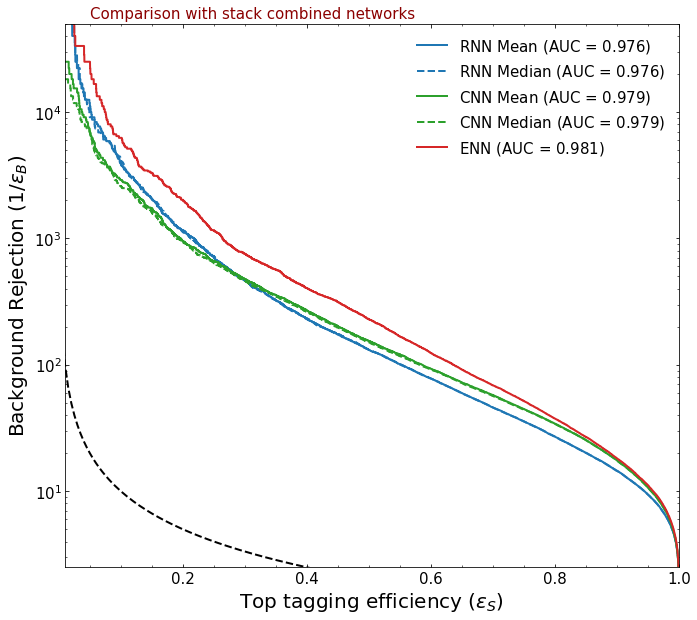

In [43]:
fig = plt.figure(figsize=(11, 10), facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

to_plot = [
           (tpr_rnn_mean, fpr_rnn_mean, auc_rnn_mean,    'RNN Mean', 'tab:blue'),
           (tpr_rnn_median, fpr_rnn_median, auc_rnn_median,    'RNN Median', 'tab:blue'),
           (tpr_cnn_mean, fpr_cnn_mean, auc_cnn_mean,    'CNN Mean', 'tab:green'),
           (tpr_cnn_median, fpr_cnn_median, auc_cnn_median,    'CNN Median', 'tab:green'),
           (tpr_enn,  fpr_enn, auc_enn,   'ENN', 'tab:red')
           ]

#axins = zoomed_inset_axes(ax, 2.2,bbox_to_anchor=(975,570))
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=".9",capstyle='round')

for tpr, fpr, auc, name, color in to_plot:
    
    ls = 'solid' if "Mean" in name or 'ENN' in name else "dashed"
    ax.plot(tpr,np.where(fpr>0.,1./fpr,1./min([x for x in fpr if x>0])),
             lw=2, label=name+' (AUC = ${:.3f}'.format(auc)+'$)', linestyle=ls,
             color=color) 

    #axins.plot(tpr,np.where(fpr>0.,1./fpr,1./min([x for x in fpr if x>0])),linestyle=ls,
    #         lw=2, color=color) 


#axins.set_xlim(.5, .8) 
#axins.set_ylim(20, 230)
axins.set_xlim(.4, .7) 
axins.set_ylim(40, 400)
#axins.set_xticks([0.5,0.6,0.7,0.8])
axins.set_xticks([0.4,0.5,0.6,.7])
axins.set_xlabel('$\epsilon_S$')
axins.set_ylabel('$1/\epsilon_B$')

x = np.linspace(min([x for x in fpr_enn if x>0]),1.,200)
ax.plot(x, 1./x, 'k--', lw=2)

#ax.plot([0.5,.5],[5,3e2],linestyle='dashed',color='darkred',zorder=0)
#ax.plot([0.8,.8],[1.8e1,3e3],linestyle='dashed',color='darkred',zorder=0)

#plt.text(0.51,1.2e1,'$\epsilon_S = 0.5$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.28,8e1,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean5),fontsize=15,color='darkred')
#ax.text(0.27,3.25e1,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean5),fontsize=15,color='darkred')
#ax.text(0.28,1.2e1,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean5),fontsize=15,color='darkred')
#ax.text(0.28,5,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean5),fontsize=15,color='darkred')

#plt.text(0.81,2e2,'$\epsilon_S = 0.8$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.6,2e3,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean8),fontsize=15,color='darkred')
#ax.text(0.59,8e2,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean8),fontsize=15,color='darkred')
#ax.text(0.6,2.2e1*10+100,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean8),fontsize=15,color='darkred')
#ax.text(0.6,1.5e2,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean8),fontsize=15,color='darkred')



ax.set_yscale('log')
ax.set_ylabel('Background Rejection ($1/\epsilon_B$)',fontsize=20)
ax.set_xlabel('Top tagging efficiency ($\epsilon_S$)',fontsize=20)
leg = ax.legend(loc='best',fontsize=15,ncol=1)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax.set_ylim([2.5,5e4])
ax.set_xlim([0.01,1])
#all_auc = np.array([item for key, item in roc_dict.items() if 'auc' in key])
#plt.title(r"AUC = $ {:.4f} \pm {:.4f}$".format(all_auc.mean(), all_auc.std()/np.sqrt(float(len(all_auc))) ))
plt.text(0.05,5.5e4,'Comparison with stack combined networks',color='darkred',fontsize=15)
plt.savefig('roc_stackcombcomp_1110.png',bbox_inches = 'tight')
plt.show()

# Comparisson of bayesian networks with different number of training samples

In [3]:
main_path = 'EnsembleNN/refrep/'
from EnsembleNN.Models.simpleBRNN             import BayesModel as BRNN
from EnsembleNN.Models.simpleBCNN             import BayesModel as BCNN
from EnsembleNN.Models.simpleBENN             import BayesModel as BENN
from EnsembleNN.Models.simpleBENN_singlelayer import BayesModel as BENN_single

model_rnn20 = BRNN(1.)
model_rnn20.load_weights(main_path+'brnn/BRNNf20_0/brnn_model.h5')
model_rnn30 = BRNN(1.)
model_rnn30.load_weights(main_path+'brnn/BRNNf30_0/brnn_model.h5')
model_rnn61 = BRNN(1.)
model_rnn61.load_weights(main_path+'brnn/BRNNf61_0/brnn_model.h5')

model_cnn20 = BCNN(1.)
model_cnn20.load_weights(main_path+'bcnn/BCNNf20_0/bcnn_model.h5')
model_cnn30 = BCNN(1.)
model_cnn30.load_weights(main_path+'bcnn/BCNNf30_0/bcnn_model.h5')
model_cnn61 = BCNN(1.)
model_cnn61.load_weights(main_path+'bcnn/BCNNf61_0/bcnn_model.h5')

model_enn20 = BENN(1.)
model_enn20.load_weights(main_path+'benn/BENNf20_0/benn_model.h5')
model_enn30 = BENN(1.)
model_enn30.load_weights(main_path+'benn/BENNf30_0/benn_model.h5')
model_enn61 = BENN(1.)
model_enn61.load_weights(main_path+'benn/BENNf61_0/benn_model.h5')

# Single layer
model_enn_single20 = BENN_single(1.)
model_enn_single20.load_weights(main_path+'benn2/BENN2f20_0/benn2_model.h5')
model_enn_single30 = BENN_single(1.)
model_enn_single30.load_weights(main_path+'benn2/BENN2f30_0/benn2_model.h5')
model_enn_single61 = BENN_single(1.)
model_enn_single61.load_weights(main_path+'benn2/BENN2f61_0/benn2_model.h5')

Instructions for updating:
Please use `layer.add_weight` method instead.


In [5]:
from EnsembleNN.system.feedback import progress

N = 100

test.Reset()
test.shuffle    = False
test.batch_size = 100000

X_test, y_test = test[0]
for ix in range(N):
    progress(ix, N-1)
    yhat_rnn20_tmp = model_rnn20(X_test[1], training=False)
    yhat_rnn30_tmp = model_rnn30(X_test[1], training=False)
    yhat_rnn61_tmp = model_rnn61(X_test[1], training=False)
    
    yhat_cnn20_tmp = model_cnn20(X_test[0], training=False)
    yhat_cnn30_tmp = model_cnn30(X_test[0], training=False)
    yhat_cnn61_tmp = model_cnn61(X_test[0], training=False)
    
    yhat_enn20_tmp = model_enn20(X_test, training=False)
    yhat_enn30_tmp = model_enn30(X_test, training=False)
    yhat_enn61_tmp = model_enn61(X_test, training=False)
    
    yhat_enn_single20_tmp = model_enn_single20(X_test, training=False)
    yhat_enn_single30_tmp = model_enn_single30(X_test, training=False)
    yhat_enn_single61_tmp = model_enn_single61(X_test, training=False)
    
    
    if ix == 0:
        yhat_rnn20  = yhat_rnn20_tmp
        yhat_rnn30  = yhat_rnn30_tmp
        yhat_rnn61  = yhat_rnn61_tmp
        
        yhat_cnn20  = yhat_cnn20_tmp
        yhat_cnn30  = yhat_cnn30_tmp
        yhat_cnn61  = yhat_cnn61_tmp
        
        yhat_enn20  = yhat_enn20_tmp
        yhat_enn30  = yhat_enn30_tmp
        yhat_enn61  = yhat_enn61_tmp
        
        yhat_enn_single20  = yhat_enn_single20_tmp
        yhat_enn_single30  = yhat_enn_single30_tmp
        yhat_enn_single61  = yhat_enn_single61_tmp

    else:
        yhat_rnn20  = np.hstack((yhat_rnn20,  yhat_rnn20_tmp))
        yhat_rnn30  = np.hstack((yhat_rnn30,  yhat_rnn30_tmp))
        yhat_rnn61  = np.hstack((yhat_rnn61,  yhat_rnn61_tmp))
        
        yhat_cnn20  = np.hstack((yhat_cnn20,  yhat_cnn20_tmp))
        yhat_cnn30  = np.hstack((yhat_cnn30,  yhat_cnn30_tmp))
        yhat_cnn61  = np.hstack((yhat_cnn61,  yhat_cnn61_tmp))
        
        yhat_enn20  = np.hstack((yhat_enn20,  yhat_enn20_tmp))
        yhat_enn30  = np.hstack((yhat_enn30,  yhat_enn30_tmp))
        yhat_enn61  = np.hstack((yhat_enn61,  yhat_enn61_tmp))
        
        yhat_enn_single20  = np.hstack((yhat_enn_single20,  yhat_enn_single20_tmp))
        yhat_enn_single30  = np.hstack((yhat_enn_single30,  yhat_enn_single30_tmp))
        yhat_enn_single61  = np.hstack((yhat_enn_single61,  yhat_enn_single61_tmp))

test.Reset()
del X_test, y_test, yhat_rnn30_tmp, yhat_rnn61_tmp, yhat_cnn20_tmp, yhat_cnn30_tmp, yhat_cnn61_tmp,yhat_enn20_tmp,yhat_enn30_tmp
del yhat_enn61_tmp, yhat_enn_single20_tmp, yhat_enn_single30_tmp,yhat_enn_single61_tmp

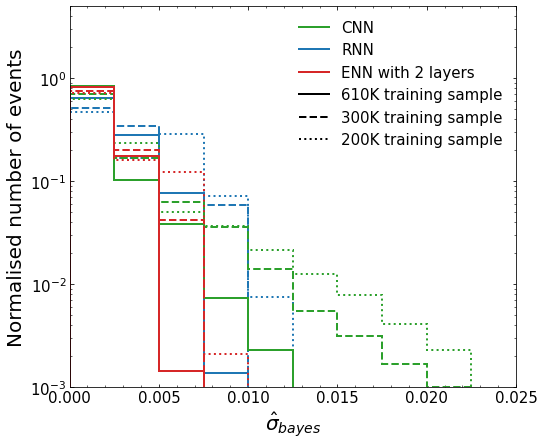

In [47]:
from matplotlib.lines import Line2D
fig  = plt.figure(figsize=(8, 7))

for yhat,color,label, ls in to_plot:

    plt.hist(yhat.std(axis=1),bins=np.linspace(0.,.025,11),
             histtype="step", rwidth=1.0,
             weights=np.ones(yhat.std(axis=1).shape[0])/float(yhat.std(axis=1).shape[0]),
            color=None, edgecolor=color, linewidth=2., linestyle=ls,
            bottom=None, cumulative=False, density=False, align="mid", orientation="vertical")

legend_elements = [Line2D([0], [0], color='tab:green', lw=2, label=r'CNN'),
                   Line2D([0], [0], color='tab:blue', lw=2, label=r'RNN'),
                   Line2D([0], [0], color='tab:red', lw=2, label=r'ENN with 2 layers'),
                   Line2D([0], [0], color='k', lw=2, linestyle='solid',label=r'610K training sample'),
                   Line2D([0], [0], color='k', lw=2, linestyle='dashed',label=r'300K training sample'),
                   Line2D([0], [0], color='k', lw=2, linestyle='dotted',label=r'200K training sample'),]
    
leg = plt.legend(handles=legend_elements, loc='upper right', fontsize=15, ncol=1)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
    
plt.yscale('log')
plt.xlim([0,.025])
plt.ylim([1e-3,5])
plt.xlabel(r'$\hat{\sigma}_{bayes}$')
plt.ylabel('Normalised number of events')
#plt.xticks([0,0.002,0.004,0.006,0.008,0.01],[0,0.002,0.004,0.006,0.008,0.01])
plt.savefig("bayes_comparisson.png", bbox_inches = 'tight')
plt.show()